# Import Libraries

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

warnings.filterwarnings("ignore")

# Read csv file (Phase 2 data)

In [2]:
# Load your CSV
df = pd.read_csv(
    "combined_good_coil_data_added gauge target and phases_Phase 2_Gauge lst 0.08_std4.csv"
)

# Select the desired coil ID and Desired Signal

In [3]:
# Pick one coil id from your dataset
example_coil_id = 2804656  # put a known coil id

# Filter only that coil’s data
coil_data = df[df["STD4_ID"] == example_coil_id].copy()

signal = "Stand 4 OS Roll Force"  # put a known signal

coil_data["STD4_ID"] = coil_data["STD4_ID"].astype(int)

In [4]:
coil_data

,Coil ID,Coil Length [30ms],Master Ramp,Shape Target Second Coefficient,Stand 1 Predicted Run Force,Stand 1 Gap Stick Offset,Tension Reel Calculated Tension,Stand 1-2 Total Tension Feedback,Stand 3 - Operator Side Force,Stand 1 Run Gap Setpoint,...,Roll Force Hydraulics Pressure Feedback,Stand 1 Roll Force,Stand 1 Roll Force limit (g67 delayed 200 ms + g80),Stand 1 Roll Force Increase Limit (based on predicted run force),Stand 4 OS Bending Shape Trim,Stand 4 DS Bending Shape Trim,Shape Target Second Coefficient.1,X4 Gauge Target,Phase,STD4_ID
2975,5400236,1161.3334,100.0,10.0,1204.0,0.0,5.700003,30.809998,601.58200,59.600098,...,2979.6667,1172.7,1289.9,120.0,-44.861990,14.481533,10.0,-0.011136,Phase 2,2804656
2976,5400236,1185.3334,100.0,10.0,1204.0,0.0,5.627002,29.873999,615.38824,59.600098,...,2978.0000,1173.9,1302.8,120.0,-45.508057,14.433608,10.0,-0.001363,Phase 2,2804656
2977,5400236,1190.0000,100.0,10.0,1204.0,0.0,5.630005,30.521988,601.51910,59.600098,...,2976.0000,1159.8,1314.2,120.0,-45.725365,14.366670,10.0,-0.008816,Phase 2,2804656
2978,5400236,1194.7500,100.0,10.0,1204.0,0.0,5.600992,30.371012,605.91290,59.600098,...,2976.5000,1163.0,1299.9,120.0,-45.911720,14.223965,10.0,-0.009657,Phase 2,2804656
2979,5400236,1223.2500,100.0,10.0,1204.0,0.0,5.534003,30.366993,601.32996,59.600098,...,2981.0000,1178.6,1304.9,120.0,-46.835045,13.873047,10.0,-0.017516,Phase 2,2804656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3881,5400236,8973.3330,100.0,10.0,1204.0,0.0,3.517996,30.605999,629.39790,59.600098,...,2977.0000,1180.9,1319.9,120.0,28.822618,35.003070,10.0,-0.007772,Phase 2,2804656
3882,5400236,8977.6670,100.0,10.0,1204.0,0.0,3.525995,31.159992,638.66400,59.600098,...,2977.6667,1161.1,1319.9,120.0,28.903870,34.892350,10.0,-0.010527,Phase 2,2804656
3883,5400236,8982.2500,100.0,10.0,1204.0,0.0,3.535004,30.211002,636.68650,59.600098,...,2976.2500,1171.0,1307.4,120.0,29.026272,34.929010,10.0,-0.001015,Phase 2,2804656
3884,5400236,9006.0000,100.0,10.0,1204.0,0.0,3.526996,31.133005,631.64700,59.600098,...,2973.6667,1201.8,1326.7,120.0,29.417350,35.215374,10.0,-0.005046,Phase 2,2804656


# Anomaly Detection - Isolation Forest

In [45]:
def detect_anomalies(coil_data, signal_cols):
    """
    Run anomaly detection for one coil:
    - IsolationForest for overall anomaly detection
    - IQR method for per-signal anomaly %
    """
    # Standardize only IBA signals
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(coil_data[signal_cols])

    # Isolation Forest for anomaly detection
    iso = IsolationForest(contamination=0.05, random_state=42)
    y_pred = iso.fit_predict(X_scaled)

    # Add anomaly flag (-1 = anomaly, 1 = normal)
    coil_data["Anomaly"] = y_pred

    # Overall anomaly percentage
    anomaly_percentage = (coil_data["Anomaly"] == -1).mean() * 100

    # Per-signal anomaly percentage (using IQR method)
    anomaly_per_signal = {}
    for sig in signal_cols:
        q1 = coil_data[sig].quantile(0.25)
        q3 = coil_data[sig].quantile(0.75)
        iqr = q3 - q1
        lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        anomaly_per_signal[sig] = (
            (coil_data[sig] < lower) | (coil_data[sig] > upper)
        ).mean() * 100

    return anomaly_percentage, anomaly_per_signal, coil_data

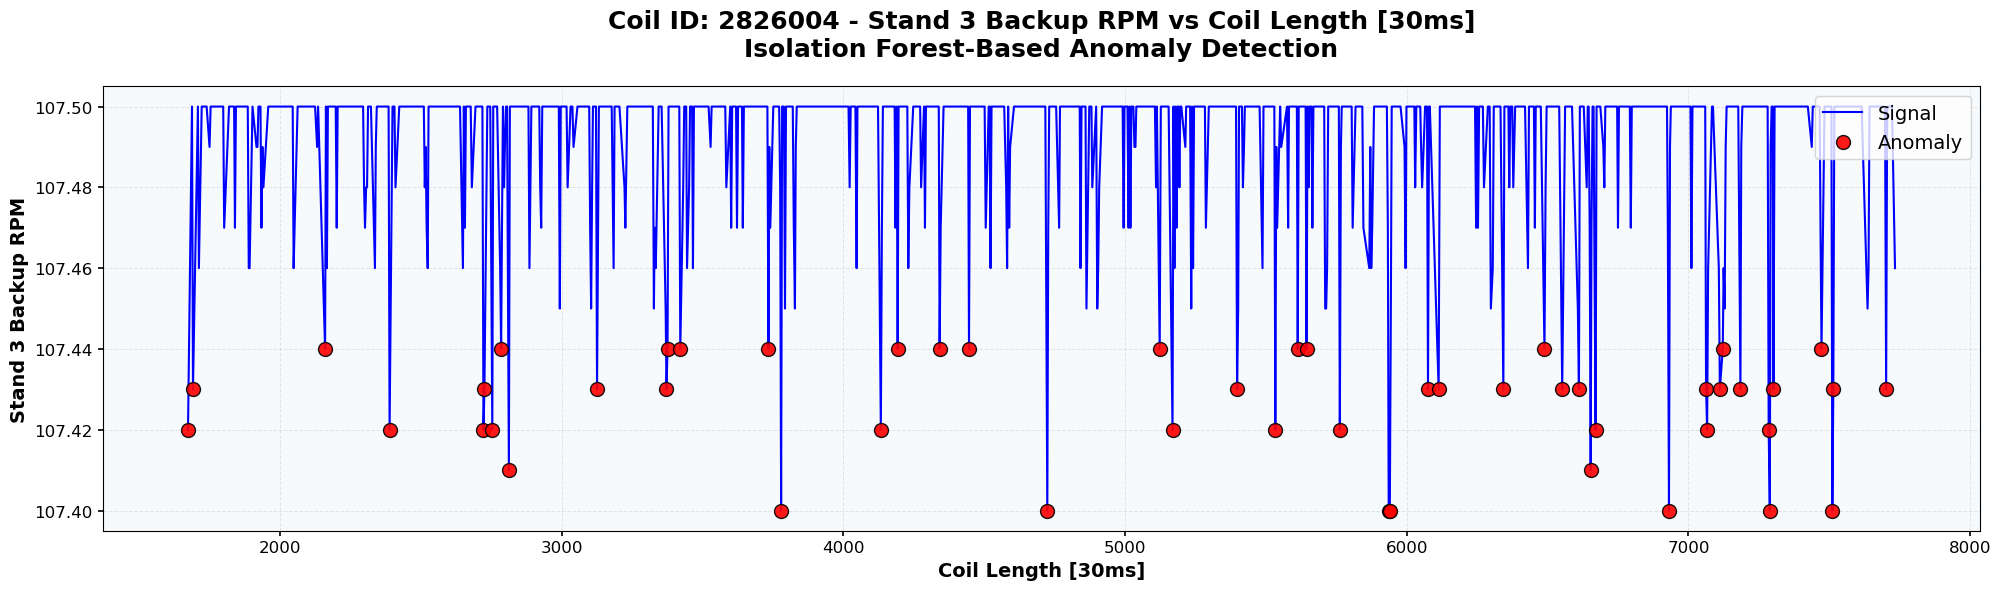

In [46]:
_, _, coil_with_anoms = detect_anomalies(coil_data, [signal])

# Get coil id (since your df only has one coil, just take the first unique value)
coil_id = coil_with_anoms["STD4_ID"].iloc[0]

plt.figure(figsize=(20, 6))

# Plot full signal as line
plt.plot(
    coil_with_anoms["Coil Length [30ms]"],
    coil_with_anoms[signal],
    color="blue",  # deep blue for signal
    linewidth=1.5,
    label="Signal",
)

# Highlight anomalies on top (red circles with black edge)
anomaly_points = coil_with_anoms[coil_with_anoms["Anomaly"] == -1]
plt.scatter(
    anomaly_points["Coil Length [30ms]"],
    anomaly_points[signal],
    color="red",
    edgecolors="black",
    marker="o",
    s=100,
    alpha=0.9,
    label="Anomaly",
    zorder=5,
)

plt.title(
    f"Coil ID: {coil_id} - {signal} vs Coil Length [30ms]\nIsolation Forest-Based Anomaly Detection",
    fontsize=18,
    fontweight="bold",
    pad=22,
)
plt.xlabel("Coil Length [30ms]", fontsize=14, fontweight="bold")
plt.ylabel(signal, fontsize=14, fontweight="bold")
plt.legend(fontsize=14, loc="upper right")
plt.grid(True, color="#cccccc", linestyle="--", linewidth=0.7, alpha=0.5)
plt.tight_layout()

# Optionally make ticks larger and add a subtle background
plt.tick_params(axis="both", labelsize=12, width=1.2)
plt.gca().set_facecolor("#f7fafc")

plt.show()

# Anomaly Detection - Volatility

Signal: Stand 3 Backup RPM
Mean: 107.4920
Std Dev: 0.0189
Lower Bound: 107.4541
Upper Bound: 107.5299
Anomaly Count: 68
Anomaly Percentage: 6.42%


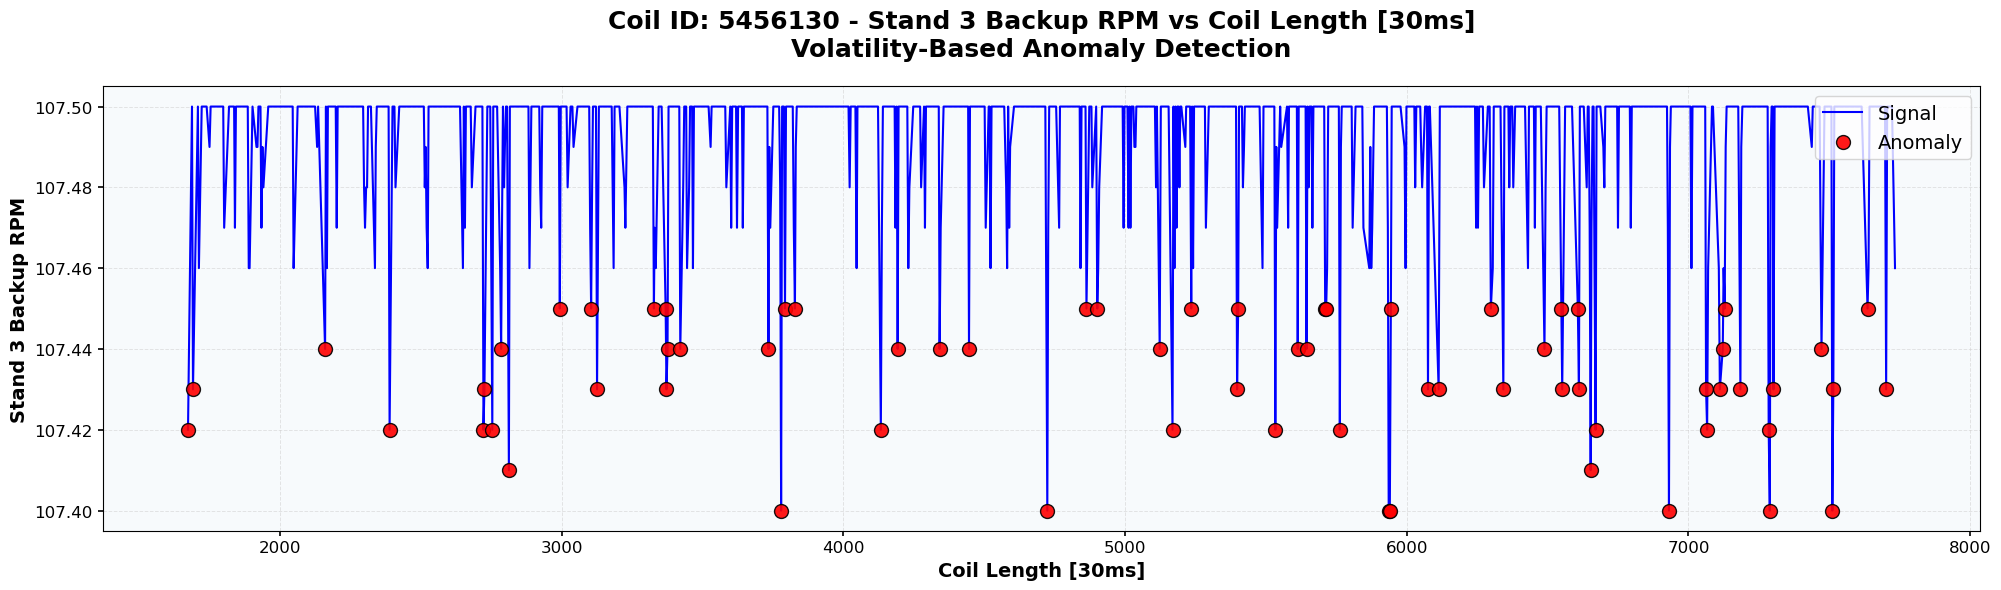

In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def detect_anomalies_global(
    df, signal_cols, x_col="Coil Length [30ms]", threshold_factor=2
):
    df_sorted = df.sort_values(x_col).copy()
    df_sorted = df_sorted.reset_index(drop=True)
    is_anomaly = pd.Series([False] * len(df_sorted), index=df_sorted.index)

    # Dictionary to store bounds for each signal
    bounds_info = {}

    for signal_col in signal_cols:
        series = df_sorted[signal_col]
        mean = series.mean()
        std = series.std()
        upper = mean + threshold_factor * std
        lower = mean - threshold_factor * std
        is_anomaly = is_anomaly | (series > upper) | (series < lower)

        # Store bounds info
        bounds_info[signal_col] = {
            "mean": mean,
            "std": std,
            "lower_bound": lower,
            "upper_bound": upper,
        }

    df_sorted["Anomaly"] = np.where(is_anomaly, -1, 1)
    anomaly_count = (df_sorted["Anomaly"] == -1).sum()
    anomaly_pct = 100 * anomaly_count / len(df_sorted)
    return anomaly_pct, anomaly_count, df_sorted, bounds_info


# --- Usage ---
anomaly_pct, anomaly_count, coil_with_anoms, bounds_info = detect_anomalies_global(
    coil_data, [signal]
)

# Print bounds information
print("=" * 60)
print(f"Signal: {signal}")
print(f"Mean: {bounds_info[signal]['mean']:.4f}")
print(f"Std Dev: {bounds_info[signal]['std']:.4f}")
print(f"Lower Bound: {bounds_info[signal]['lower_bound']:.4f}")
print(f"Upper Bound: {bounds_info[signal]['upper_bound']:.4f}")
print(f"Anomaly Count: {anomaly_count}")
print(f"Anomaly Percentage: {anomaly_pct:.2f}%")
print("=" * 60)

# Get coil id (assuming single coil in df)
coil_id = (
    coil_with_anoms["Coil ID"].iloc[0]
    if "Coil ID" in coil_with_anoms.columns
    else "Unknown"
)

plt.figure(figsize=(20, 6))

# Plot full signal as line
plt.plot(
    coil_with_anoms["Coil Length [30ms]"],
    coil_with_anoms[signal],
    color="blue",
    linewidth=1.5,
    label="Signal",
)

# Highlight anomalies on top (red circles with black edge)
anomaly_points = coil_with_anoms[coil_with_anoms["Anomaly"] == -1]
plt.scatter(
    anomaly_points["Coil Length [30ms]"],
    anomaly_points[signal],
    color="red",
    edgecolors="black",
    marker="o",
    s=100,
    alpha=0.9,
    label="Anomaly",
    zorder=5,
)

plt.title(
    f"Coil ID: {coil_id} - {signal} vs Coil Length [30ms]\nVolatility-Based Anomaly Detection",
    fontsize=18,
    fontweight="bold",
    pad=22,
)
plt.xlabel("Coil Length [30ms]", fontsize=14, fontweight="bold")
plt.ylabel(signal, fontsize=14, fontweight="bold")
plt.legend(fontsize=14, loc="upper right")
plt.grid(True, color="#cccccc", linestyle="--", linewidth=0.7, alpha=0.5)
plt.tight_layout()

# Optionally make ticks larger and add a subtle background
plt.tick_params(axis="both", labelsize=12, width=1.2)
plt.gca().set_facecolor("#f7fafc")
plt.show()

# Anomaly Detection - Volatility (Phase 2 is divided into 10 equal parts)

Signal: Stand 3 Backup RPM
Segment 1: Anomalies = 8, Percentage = 7.55%
Segment 2: Anomalies = 6, Percentage = 5.66%
Segment 3: Anomalies = 8, Percentage = 7.55%
Segment 4: Anomalies = 5, Percentage = 4.72%
Segment 5: Anomalies = 7, Percentage = 6.60%
Segment 6: Anomalies = 6, Percentage = 5.66%
Segment 7: Anomalies = 7, Percentage = 6.60%
Segment 8: Anomalies = 7, Percentage = 6.60%
Segment 9: Anomalies = 8, Percentage = 7.55%
Segment 10: Anomalies = 8, Percentage = 7.55%
Total anomalies: 70 (6.60%)


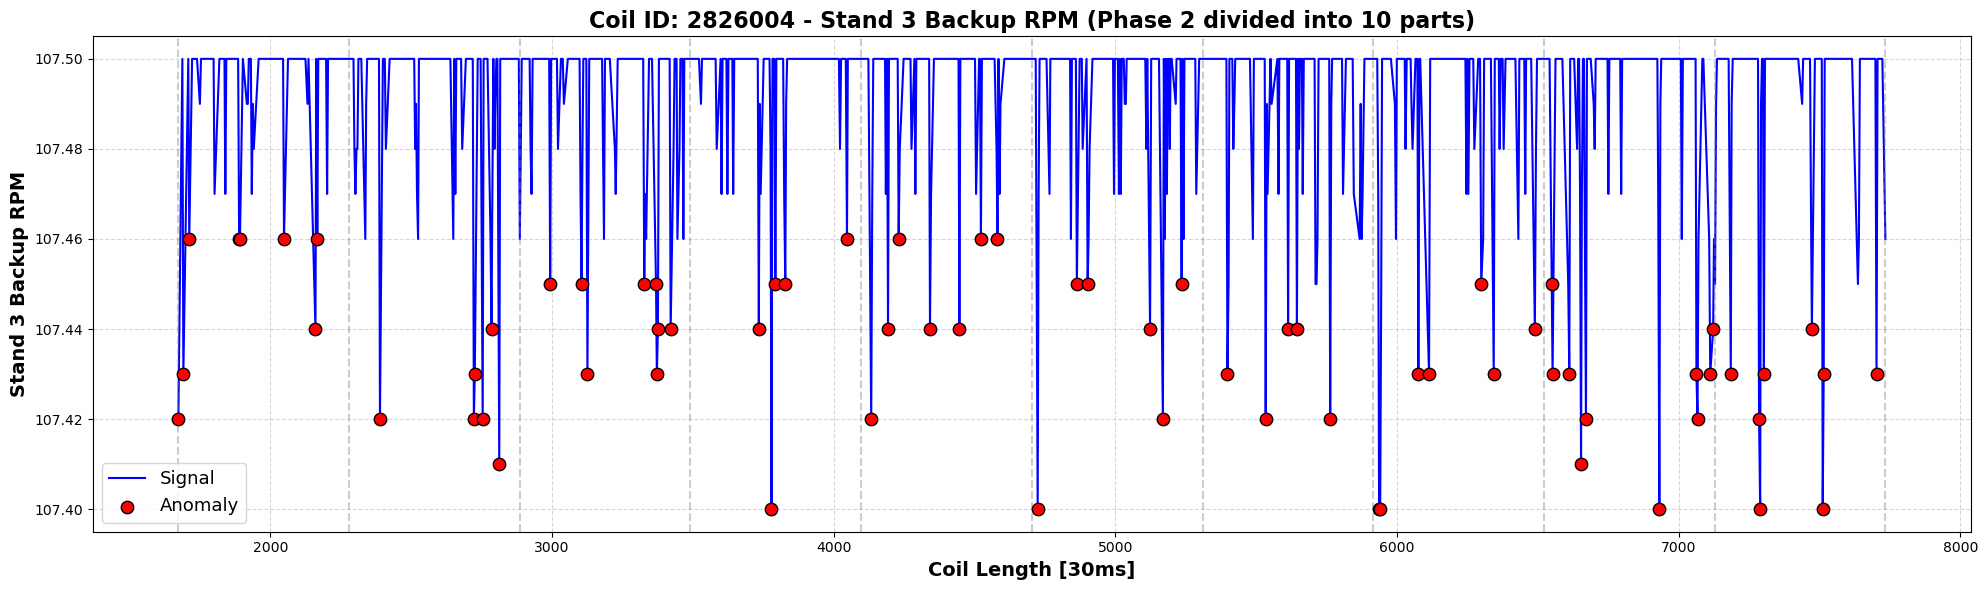

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def detect_anomalies_by_segments(
    df, signal_cols, x_col="Coil Length [30ms]", threshold_factor=2, n_segments=10
):
    df_sorted = df.sort_values(x_col).reset_index(drop=True)
    total_len = len(df_sorted)
    segment_size = total_len // n_segments

    df_sorted["Anomaly"] = 1  # Default = normal
    bounds_info = {}
    anomaly_summary = []

    for i in range(n_segments):
        start_idx = i * segment_size
        end_idx = (i + 1) * segment_size if i < n_segments - 1 else total_len
        segment_df = df_sorted.iloc[start_idx:end_idx]

        for signal_col in signal_cols:
            series = segment_df[signal_col]
            mean = series.mean()
            std = series.std()
            upper = mean + threshold_factor * std
            lower = mean - threshold_factor * std

            segment_anoms = (series > upper) | (series < lower)
            df_sorted.loc[segment_df.index, "Anomaly"] = np.where(
                segment_anoms, -1, df_sorted.loc[segment_df.index, "Anomaly"]
            )

            bounds_info[f"{signal_col}_segment_{i+1}"] = {
                "segment": i + 1,
                "mean": mean,
                "std": std,
                "lower_bound": lower,
                "upper_bound": upper,
                "start_idx": start_idx,
                "end_idx": end_idx,
            }

        anomaly_count = (df_sorted.loc[segment_df.index, "Anomaly"] == -1).sum()
        anomaly_pct = 100 * anomaly_count / len(segment_df)
        anomaly_summary.append((i + 1, anomaly_count, anomaly_pct))

    total_anoms = (df_sorted["Anomaly"] == -1).sum()
    total_pct = 100 * total_anoms / len(df_sorted)

    return total_pct, total_anoms, df_sorted, bounds_info, anomaly_summary


# --- Usage ---
anomaly_pct, anomaly_count, coil_with_anoms, bounds_info, summary = (
    detect_anomalies_by_segments(coil_data, [signal], n_segments=10)
)

# Print segment summary
print("=" * 70)
print(f"Signal: {signal}")
for seg, count, pct in summary:
    print(f"Segment {seg}: Anomalies = {count}, Percentage = {pct:.2f}%")
print(f"Total anomalies: {anomaly_count} ({anomaly_pct:.2f}%)")
print("=" * 70)

# Plot
coil_id = (
    coil_with_anoms["STD4_ID"].iloc[0]
    if "STD4_ID" in coil_with_anoms.columns
    else "Unknown"
)

plt.figure(figsize=(20, 6))
plt.plot(
    coil_with_anoms["Coil Length [30ms]"],
    coil_with_anoms[signal],
    color="blue",
    linewidth=1.5,
    label="Signal",
)

# Anomaly points
anomaly_points = coil_with_anoms[coil_with_anoms["Anomaly"] == -1]
plt.scatter(
    anomaly_points["Coil Length [30ms]"],
    anomaly_points[signal],
    color="red",
    edgecolors="black",
    s=80,
    label="Anomaly",
    zorder=5,
)

# Mark segment boundaries
x_vals = coil_with_anoms["Coil Length [30ms]"].values
segment_boundaries = np.linspace(x_vals.min(), x_vals.max(), 11)
for xb in segment_boundaries:
    plt.axvline(x=xb, color="gray", linestyle="--", alpha=0.4)

plt.title(
    f"Coil ID: {coil_id} - {signal} (Phase 2 divided into 10 parts)",
    fontsize=16,
    fontweight="bold",
)
plt.xlabel("Coil Length [30ms]", fontsize=14, fontweight="bold")
plt.ylabel(signal, fontsize=14, fontweight="bold")
plt.legend(fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Anomaly Detection - Volatility (Phase 2 is divided at every 500m of Coil length)

Signal: Stand 3 Backup RPM
Coil Length 1673-2173 m: Anomalies = 3, Percentage = 3.70%
Coil Length 2173-2673 m: Anomalies = 4, Percentage = 4.76%
Coil Length 2673-3173 m: Anomalies = 6, Percentage = 6.52%
Coil Length 3173-3673 m: Anomalies = 5, Percentage = 5.56%
Coil Length 3673-4173 m: Anomalies = 5, Percentage = 5.81%
Coil Length 4173-4673 m: Anomalies = 6, Percentage = 6.82%
Coil Length 4673-5173 m: Anomalies = 5, Percentage = 5.43%
Coil Length 5173-5673 m: Anomalies = 6, Percentage = 6.74%
Coil Length 5673-6173 m: Anomalies = 5, Percentage = 6.58%
Coil Length 6173-6673 m: Anomalies = 6, Percentage = 6.67%
Coil Length 6673-7173 m: Anomalies = 6, Percentage = 6.45%
Coil Length 7173-7673 m: Anomalies = 7, Percentage = 8.24%
Coil Length 7673-8173 m: Anomalies = 1, Percentage = 7.14%
Total anomalies: 65 (6.13%)


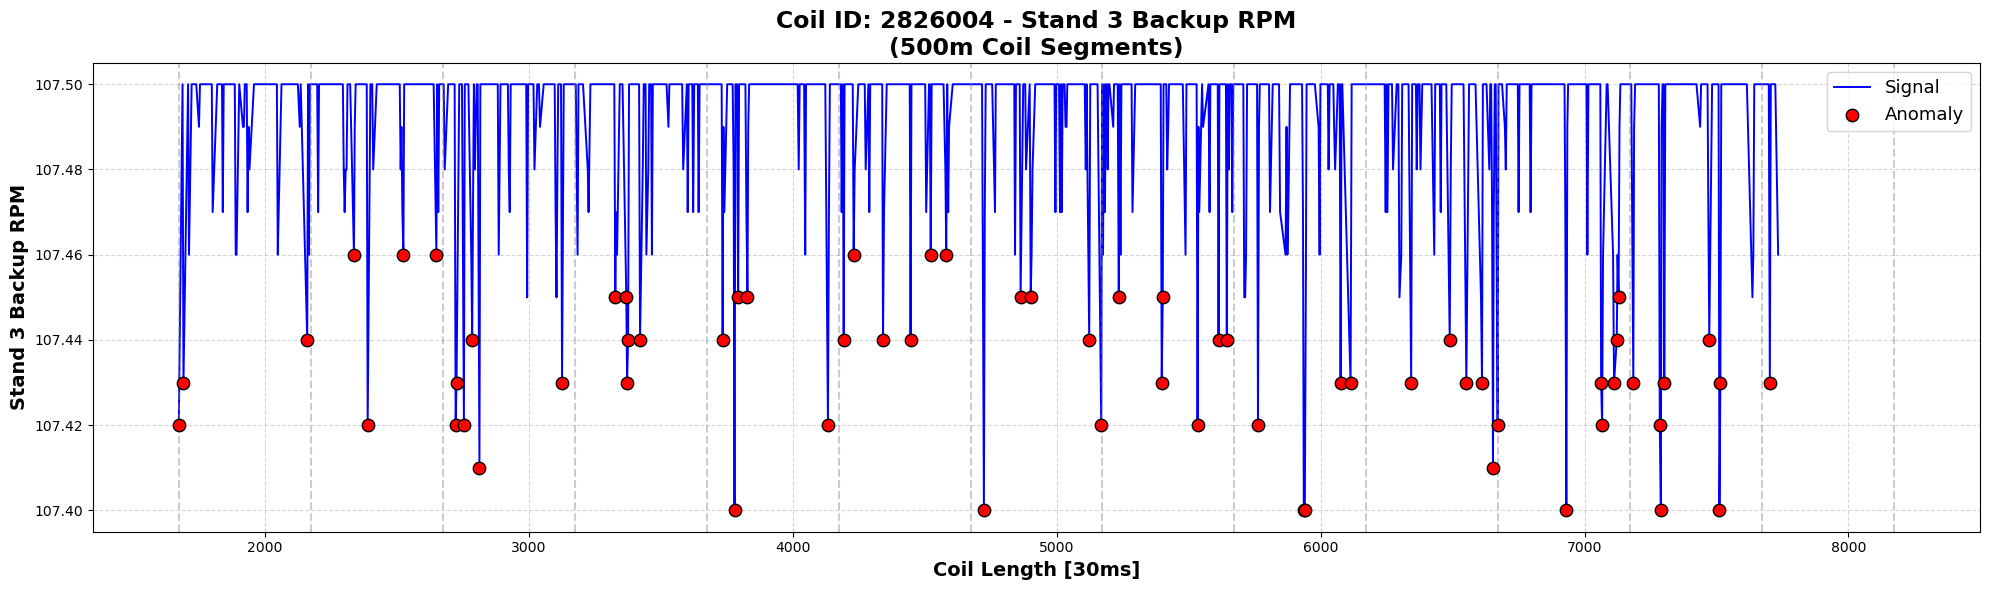

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def detect_anomalies_by_coillength(
    df, signal_cols, x_col="Coil Length [30ms]", threshold_factor=2, segment_length=500
):
    df_sorted = df.sort_values(x_col).reset_index(drop=True)
    df_sorted["Anomaly"] = 1
    bounds_info = {}
    anomaly_summary = []

    min_x = df_sorted[x_col].min()
    max_x = df_sorted[x_col].max()
    segments = np.arange(min_x, max_x + segment_length, segment_length)

    for i in range(len(segments) - 1):
        start = segments[i]
        end = segments[i + 1]
        segment_df = df_sorted[(df_sorted[x_col] >= start) & (df_sorted[x_col] < end)]

        if len(segment_df) == 0:
            continue

        for signal_col in signal_cols:
            series = segment_df[signal_col]
            mean = series.mean()
            std = series.std()
            upper = mean + threshold_factor * std
            lower = mean - threshold_factor * std

            segment_anoms = (series > upper) | (series < lower)
            df_sorted.loc[segment_df.index, "Anomaly"] = np.where(
                segment_anoms, -1, df_sorted.loc[segment_df.index, "Anomaly"]
            )

            bounds_info[f"{signal_col}_range_{start:.0f}-{end:.0f}"] = {
                "range_start": start,
                "range_end": end,
                "mean": mean,
                "std": std,
                "lower_bound": lower,
                "upper_bound": upper,
            }

        anomaly_count = (df_sorted.loc[segment_df.index, "Anomaly"] == -1).sum()
        anomaly_pct = 100 * anomaly_count / len(segment_df)
        anomaly_summary.append((f"{start:.0f}-{end:.0f}", anomaly_count, anomaly_pct))

    total_anoms = (df_sorted["Anomaly"] == -1).sum()
    total_pct = 100 * total_anoms / len(df_sorted)

    return total_pct, total_anoms, df_sorted, bounds_info, anomaly_summary


# --- Usage ---
anomaly_pct, anomaly_count, coil_with_anoms, bounds_info, summary = (
    detect_anomalies_by_coillength(
        coil_data, [signal], segment_length=500, threshold_factor=2  # 500m chunks
    )
)

# Print summary
print("=" * 75)
print(f"Signal: {signal}")
for seg, count, pct in summary:
    print(f"Coil Length {seg} m: Anomalies = {count}, Percentage = {pct:.2f}%")
print(f"Total anomalies: {anomaly_count} ({anomaly_pct:.2f}%)")
print("=" * 75)

# --- Plot ---
coil_id = (
    coil_with_anoms["STD4_ID"].iloc[0]
    if "STD4_ID" in coil_with_anoms.columns
    else "Unknown"
)

plt.figure(figsize=(20, 6))
plt.plot(
    coil_with_anoms["Coil Length [30ms]"],
    coil_with_anoms[signal],
    color="blue",
    linewidth=1.4,
    label="Signal",
)

# Anomaly points
anomaly_points = coil_with_anoms[coil_with_anoms["Anomaly"] == -1]
plt.scatter(
    anomaly_points["Coil Length [30ms]"],
    anomaly_points[signal],
    color="red",
    edgecolors="black",
    s=80,
    label="Anomaly",
    zorder=5,
)

# Draw segment boundaries
x_vals = coil_with_anoms["Coil Length [30ms]"].values
x_min, x_max = x_vals.min(), x_vals.max()
segment_lines = np.arange(x_min, x_max + 500, 500)
for xb in segment_lines:
    plt.axvline(x=xb, color="gray", linestyle="--", alpha=0.4)

plt.title(
    f"Coil ID: {coil_id} - {signal}\n(500m Coil Segments)",
    fontsize=17,
    fontweight="bold",
)
plt.xlabel("Coil Length [30ms]", fontsize=14, fontweight="bold")
plt.ylabel(signal, fontsize=14, fontweight="bold")
plt.legend(fontsize=13)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

# Anomaly Detection - Volatility (Using Rolling Window)

Signal: Stand 4 OS Roll Force
Rolling Window: 100
Z-Threshold: 2
Anomaly Count: 17
Anomaly Percentage: 1.87%


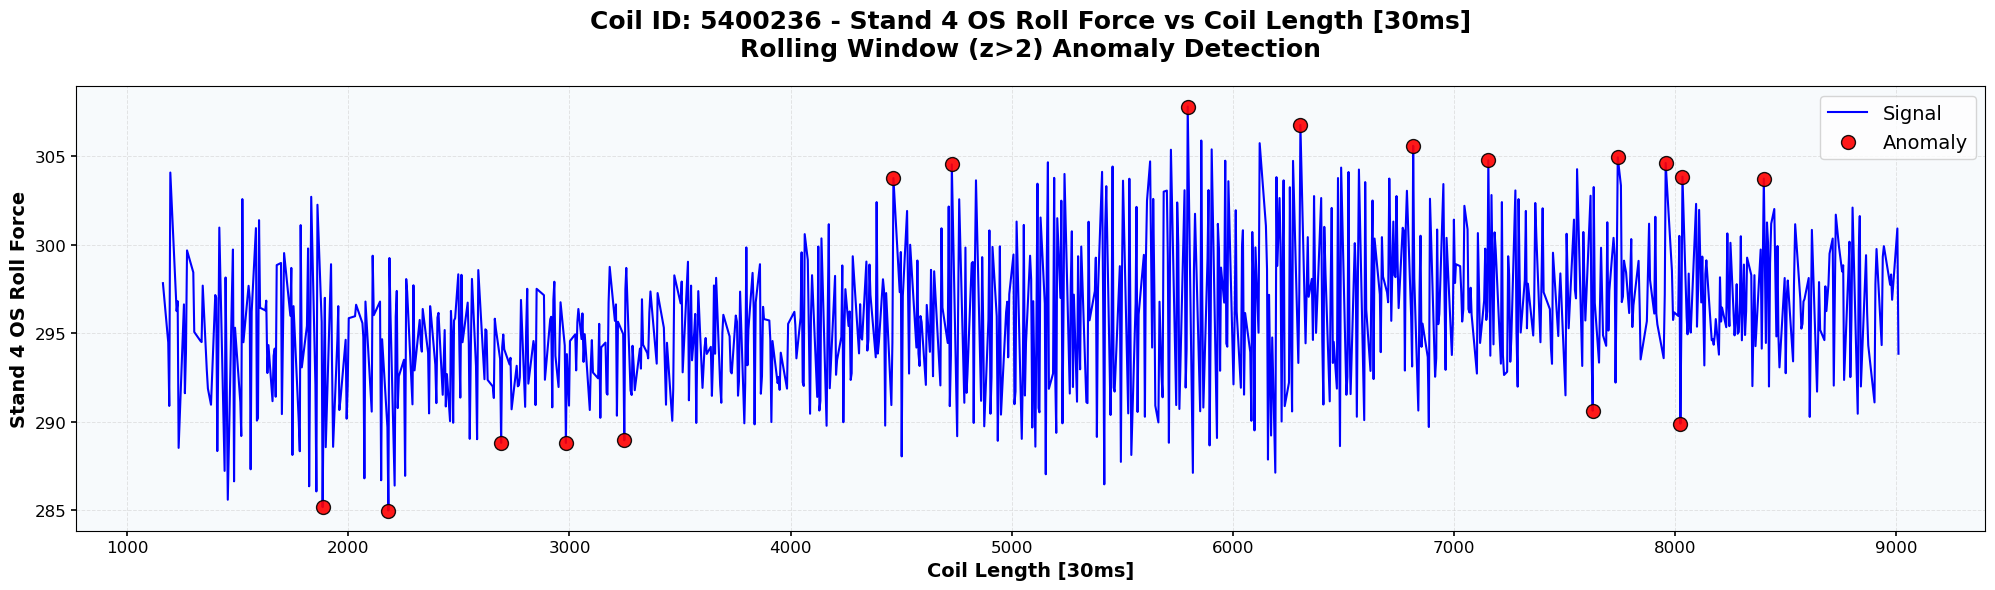

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def detect_anomalies_rolling_window(
    df, signal_cols, x_col="Coil Length [30ms]", window=250, z_thresh=2
):
    """
    Rolling window–based anomaly detection (per signal).
    """
    df_sorted = df.sort_values(x_col).reset_index(drop=True).copy()
    is_anomaly = pd.Series([False] * len(df_sorted), index=df_sorted.index)
    bounds_info = {}

    for signal_col in signal_cols:
        series = df_sorted[signal_col]

        # Rolling mean and std
        rolling_mean = series.rolling(window=window, center=True).mean()
        rolling_std = series.rolling(window=window, center=True).std()

        # Z-score and anomaly detection
        z_score = (series - rolling_mean) / (rolling_std + 1e-9)
        anomalies = z_score.abs() > z_thresh
        is_anomaly = is_anomaly | anomalies

        # Store rolling info
        bounds_info[signal_col] = {
            "z_thresh": z_thresh,
            "window": window,
        }

        # Optional: keep z-score columns for further analysis
        df_sorted[f"{signal_col}_zscore"] = z_score
        df_sorted[f"{signal_col}_AnomalyFlag"] = anomalies

    # Combine anomaly info
    df_sorted["Anomaly"] = np.where(is_anomaly, -1, 1)
    anomaly_count = (df_sorted["Anomaly"] == -1).sum()
    anomaly_pct = 100 * anomaly_count / len(df_sorted)

    return anomaly_pct, anomaly_count, df_sorted, bounds_info


# --- Usage ---
anomaly_pct, anomaly_count, coil_with_anoms, bounds_info = (
    detect_anomalies_rolling_window(coil_data, [signal], window=100, z_thresh=2)
)

print("=" * 60)
print(f"Signal: {signal}")
print(f"Rolling Window: {bounds_info[signal]['window']}")
print(f"Z-Threshold: {bounds_info[signal]['z_thresh']}")
print(f"Anomaly Count: {anomaly_count}")
print(f"Anomaly Percentage: {anomaly_pct:.2f}%")
print("=" * 60)

coil_id = (
    coil_with_anoms["Coil ID"].iloc[0]
    if "Coil ID" in coil_with_anoms.columns
    else "Unknown"
)

plt.figure(figsize=(20, 6))

# Plot signal line
plt.plot(
    coil_with_anoms["Coil Length [30ms]"],
    coil_with_anoms[signal],
    color="blue",
    linewidth=1.5,
    label="Signal",
)

# Highlight anomalies in red
anomaly_points = coil_with_anoms[coil_with_anoms["Anomaly"] == -1]
plt.scatter(
    anomaly_points["Coil Length [30ms]"],
    anomaly_points[signal],
    color="red",
    edgecolors="black",
    marker="o",
    s=100,
    alpha=0.9,
    label="Anomaly",
    zorder=5,
)

plt.title(
    f"Coil ID: {coil_id} - {signal} vs Coil Length [30ms]\nRolling Window (z>{bounds_info[signal]['z_thresh']}) Anomaly Detection",
    fontsize=18,
    fontweight="bold",
    pad=22,
)
plt.xlabel("Coil Length [30ms]", fontsize=14, fontweight="bold")
plt.ylabel(signal, fontsize=14, fontweight="bold")
plt.legend(fontsize=14, loc="upper right")
plt.grid(True, color="#cccccc", linestyle="--", linewidth=0.7, alpha=0.5)
plt.tight_layout()
plt.tick_params(axis="both", labelsize=12, width=1.2)
plt.gca().set_facecolor("#f7fafc")
plt.show()